# 03-04 Chaoticity of the Damped Driven Pendulum

## Create useful functions for investigating $\theta(t)$

Copy the functions from our previous notebook that we can use to investigate the nature of the damped driven pendulum for various driving forces.

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ode
from scipy.optimize import curve_fit

In [3]:
from IPython.display import display, Markdown, Latex

In [4]:
from vpython import * #yes, I know I'm not supposed to do this; in fact, VPython uses gamma, so I can't

<IPython.core.display.Javascript object>

Define a function that returns the derivatives in our model.

In [5]:
def model_pendulum(d, t): # y=[theta,omega]; function returns [dtheta/dt, domega/dt]    
    theta = d[0]
    omega = d[1]
    dtheta_dt = omega
    domega_dt = omega_0**2*gam*np.cos(omega_d*t) - omega_0**2*np.sin(theta)-2*beta*omega
    
    return np.array([dtheta_dt, domega_dt])

In [6]:
def run_pendulum(g=0.2, bet=3/4*np.pi, theta_i=0, omega_i=0, t_total = 10):
    
    global gam, beta, omega_0, omega_d

    omega_d = 2*np.pi
    omega_0 = 1.5*omega_d
    beta = bet
    gam = g

    t = 0.0
    h = 0.001

    data = np.array([theta_i, omega_i])
    tdata = []
    thetadata = []
    omegadata = []
    Fddata = []

    tdata.append(t)
    thetadata.append(theta_i)
    omegadata.append(omega_i)
    Fddata.append(gam*np.cos(omega_d*t))

    while t < t_total:
        #integrate
        data = ode.RK4n(model_pendulum, data, t, h) #update y[n]

        t = t + h #update clock

        tdata.append(t)
        thetadata.append(data[0])
        omegadata.append(data[1])
        Fddata.append(gam*np.cos(omega_d*t))

    return np.array(tdata), np.array(thetadata), np.array(omegadata), np.array(Fddata)

In [7]:
def plot_theta(t, theta):

    plt.figure()
    plt.plot(t,theta, 'b-', label='gamma = %.3f' % gam)
    plt.xlabel('t (s)')
    plt.ylabel('theta (rad)')
    plt.legend(loc='lower right')
    plt.show()

In [8]:
def animate_pendulum(tdata, thetadata, Fddata):
    
    theta_i=thetadata[0]
    omega_i=omegadata[0]

    scene = canvas()

    scene.background=color.white

    g = 0.8
    L = g/omega_0**2

    support = sphere(pos=vector(0,0,0), radius=L/40, color=color.orange)
    bob = sphere(pos=vector(L*np.sin(theta_i), -L*np.cos(theta_i),0), radius=L/10, color=color.yellow, make_trail=True)
    rod = cylinder(pos=support.pos, axis=bob.pos-support.pos, radius=L/70, color=color.black)
    
    gdisplay = graph(title='<b>theta(t)</b>', xtitle='<i>t</i> (s)', ytitle='<i>theta</i> (rad)', xmin=0, xmax=tdata[-1])
    
    theta_curve = gcurve(color=color.blue)

    scale=L/gam
    Fdarrow = arrow(pos=bob.pos, axis=scale*Fddata[0]*vector(np.cos(theta_i), np.sin(theta_i), 0), color=color.magenta)


    scene.waitfor("click")

    for i in range(len(thetadata)):
        rate(300)
        t = tdata[i]
        theta = thetadata[i]
        F = Fddata[i]

        bob.pos=vector(L*np.sin(theta), -L*np.cos(theta),0)

        rod.axis = bob.pos-support.pos

        Fdarrow.pos = bob.pos
        Fdarrow.axis = scale*F*vector(np.cos(theta), np.sin(theta), 0)
        
        theta_curve.plot(pos=[t,theta])

Test our functions for $\gamma=0.9,\ \beta=3\pi/4,\ \theta_i=0,\ \omega_i=0$. Note that:

- Our global variables are `global gam, beta, omega_0, omega_d`.
- Arguments for `run_pendulum()` are:

  ```python
  run_pendulum(gamma, beta, theta_i, omega_i, t_total)
  ```
  
  This returns `t_array, theta_array, Fd_array`.
  
  
- Arguments for `animate_pendulum()` are: 

  ```python
  animate_pendulum(t_array, theta_array, Fd_array)
  ```

<IPython.core.display.Javascript object>


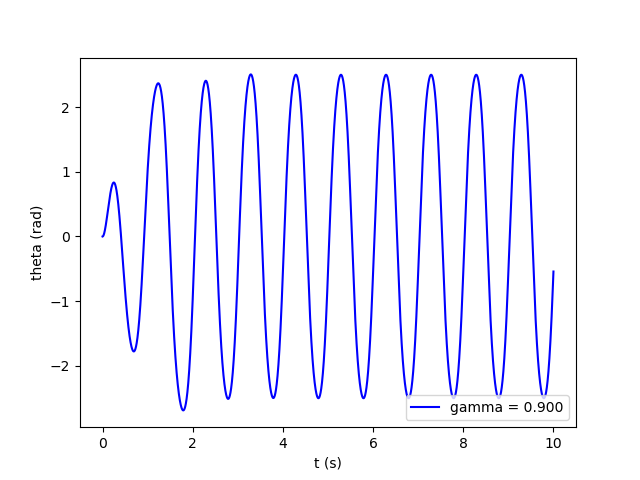

In [9]:
tdata, thetadata, omegadata, Fddata = run_pendulum(0.9, 3/4*np.pi, theta_i=0, omega_i=0, t_total = 10)

plot_theta(tdata, thetadata)

In [10]:
animate_pendulum(tdata, thetadata, Fddata)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Characterizing Steady-State $\theta(t)$

### Compare $\theta(t)$ to a pure cosine of the driving frequency

To compare the steady-state to a pure cosine function with the driving frequency, the phase should be matched. Do a curve fit to the last 1000 values of $\theta(t)$ in order to get the phase. The `fit_cos` function is adapted from [this solution](https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy) on stackoverflow.

In [12]:
def fit_cos(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    cosfunc = lambda t, A, w, p, c: A * np.cos(w*t + p) + c
    params, pcov = curve_fit(cosfunc, tt, yy, p0=guess)
    A, w, p, c = params
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

<IPython.core.display.Javascript object>


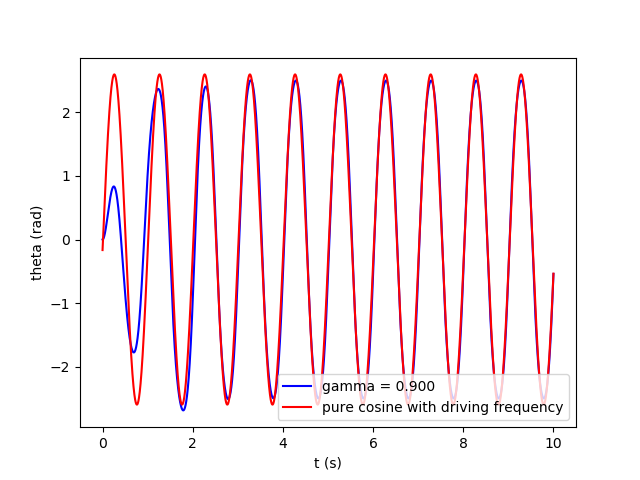

Best fit omega =  6.2681323100182125
Driving omega =  6.283185307179586


In [13]:
results = fit_cos(tdata[-2000:], thetadata[-2000:])

A_fit = results['amp']
omega_fit = results['omega']
phase_fit = results['phase']

pure_cos = A_fit*np.cos(omega_fit*tdata+phase_fit)

plt.figure()
plt.plot(tdata,thetadata, 'b-', label='gamma = %.3f' % gam)
plt.plot(tdata,pure_cos, 'r-', label='pure cosine with driving frequency')
#plt.xlim(9,10)
plt.xlabel('t (s)')
plt.ylabel('theta (rad)')
plt.legend(loc='lower right')
plt.show()

print("Best fit omega = ", omega_fit)
print("Driving omega = ", omega_d)

Note that the frequency of oscillation is (approximately) the driving frequency. We could do the curve fit at longer times to ensure that this is indeed the case. Maybe 10 s isn't enough for the system to settle into a steady state.

## Comparing Steady-State Solution At Every Period

The period of the driving frequency is 1 s, and this is the period of oscillation in the steady-state. Compare $\theta$ at each second in the steady-state.

### Period 1

<IPython.core.display.Javascript object>


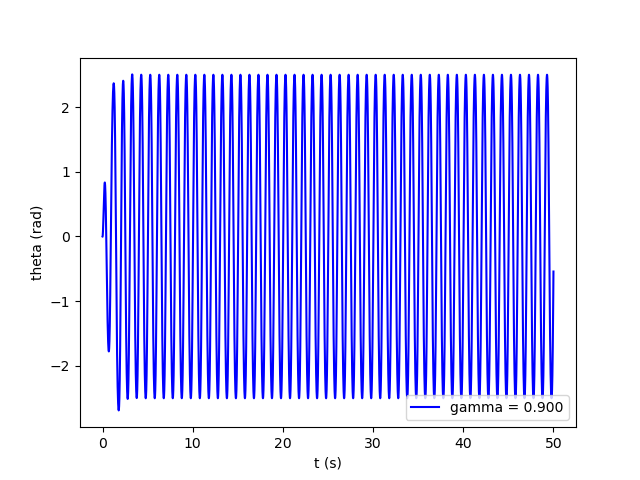

t (s) | theta (rad)
--- | ---
40 | -0.5602
41 | -0.5602
42 | -0.5602
43 | -0.5602
44 | -0.5602
45 | -0.5602
46 | -0.5602
47 | -0.5602
48 | -0.5602
49 | -0.5602

In [13]:
tdata, thetadata, omegadata, Fddata = run_pendulum(0.9, 3/4*np.pi, theta_i=0, omega_i=0, t_total = 50)

plot_theta(tdata, thetadata)

times = np.arange(40,50,1)
thetas = []

table="t (s) | theta (rad)\n--- | ---"

for t in times:
    index = np.abs(tdata-t).argmin()
    thetas.append(thetadata[index])
    table=table+"\n"+("%d | %.4f" % (t, thetadata[index]))

display(Markdown(table))


### Period One - Stonger Driving

<IPython.core.display.Javascript object>


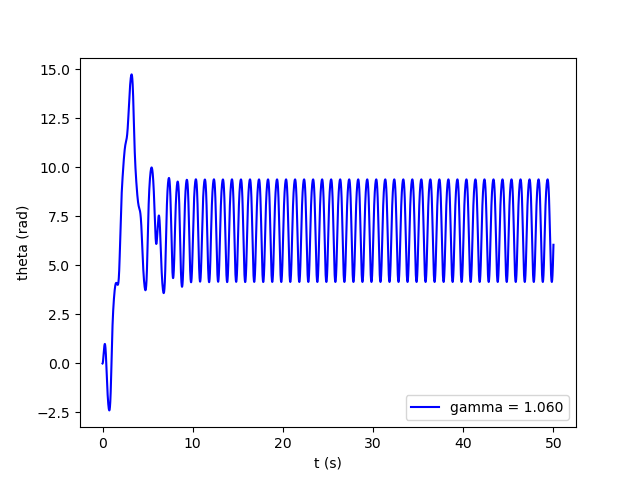

t (s) | theta (rad)
--- | ---
40 | 6.0366
41 | 6.0366
42 | 6.0366
43 | 6.0366
44 | 6.0366
45 | 6.0366
46 | 6.0366
47 | 6.0366
48 | 6.0366
49 | 6.0366

In [14]:
tdata, thetadata, omegadata, Fddata = run_pendulum(1.06, 3/4*np.pi, theta_i=0, omega_i=0, t_total = 50)

plot_theta(tdata, thetadata)

times = np.arange(40,50,1)
thetas = []

table="t (s) | theta (rad)\n--- | ---"

for t in times:
    index = np.abs(tdata-t).argmin()
    thetas.append(thetadata[index])
    table=table+"\n"+("%d | %.4f" % (t, thetadata[index]))

display(Markdown(table))


### Period Two

<IPython.core.display.Javascript object>


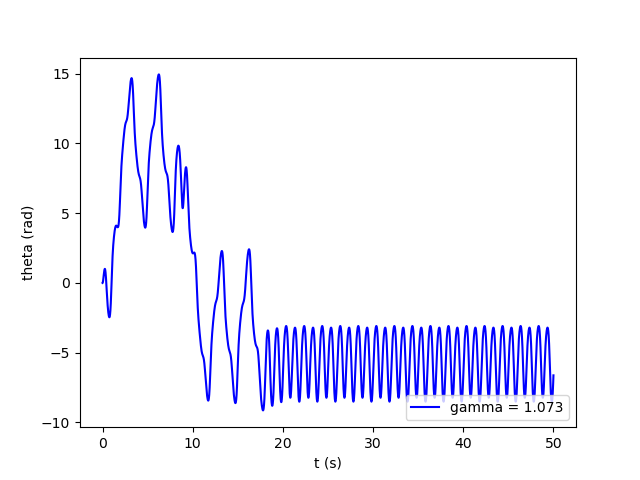

t (s) | theta (rad)
--- | ---
40 | -6.6438
41 | -6.4090
42 | -6.6438
43 | -6.4090
44 | -6.6438
45 | -6.4090
46 | -6.6438
47 | -6.4090
48 | -6.6438
49 | -6.4090

In [15]:
tdata, thetadata, omegadata, Fddata = run_pendulum(1.073, 3/4*np.pi, theta_i=0, omega_i=0, t_total = 50)

plot_theta(tdata, thetadata)

times = np.arange(40,50,1)
thetas = []

table="t (s) | theta (rad)\n--- | ---"

for t in times:
    index = np.abs(tdata-t).argmin()
    thetas.append(thetadata[index])
    table=table+"\n"+("%d | %.4f" % (t, thetadata[index]))

display(Markdown(table))

### Period Three

<IPython.core.display.Javascript object>


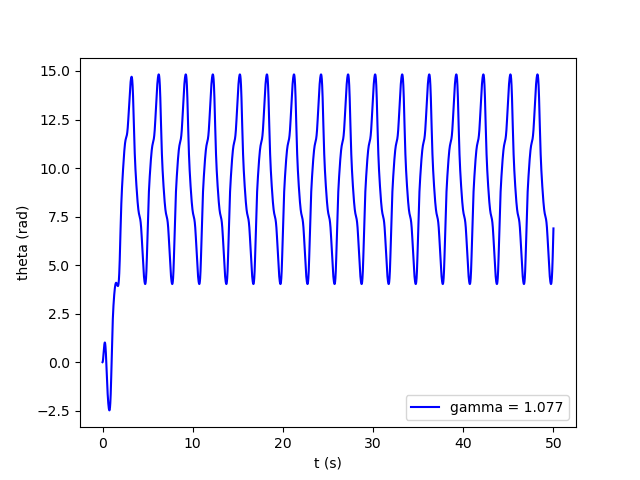

t (s) | theta (rad)
--- | ---
40 | 7.7585
41 | 6.8727
42 | 13.8122
43 | 7.7585
44 | 6.8727
45 | 13.8122
46 | 7.7585
47 | 6.8727
48 | 13.8122
49 | 7.7585

In [16]:
tdata, thetadata, omegadata, Fddata = run_pendulum(1.077, 3/4*np.pi, theta_i=0, omega_i=0, t_total = 50)

plot_theta(tdata, thetadata)

times = np.arange(40,50,1)
thetas = []

table="t (s) | theta (rad)\n--- | ---"

for t in times:
    index = np.abs(tdata-t).argmin()
    thetas.append(thetadata[index])
    table=table+"\n"+("%d | %.4f" % (t, thetadata[index]))

display(Markdown(table))

### Different Initial Conditions Can Result in Different Attractors

Here is $\gamma=1.077$ with the initial conditions $\phi_i=-\pi/2,\ \omega=0$. With these initial conditions, you get two attractors.

<IPython.core.display.Javascript object>


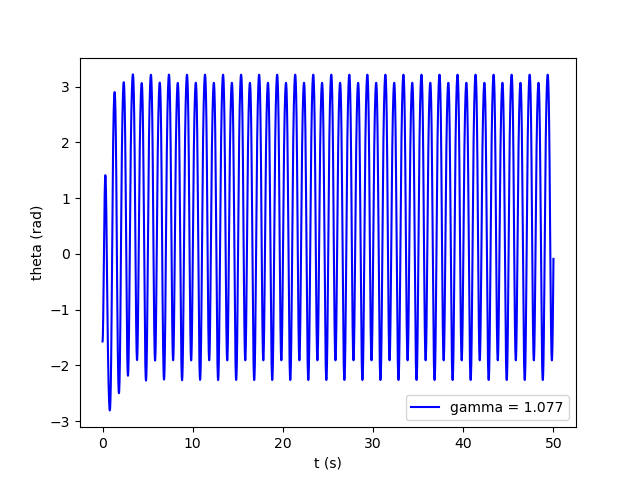

t (s) | theta (rad)
--- | ---
40 | -0.1071
41 | -0.4050
42 | -0.1071
43 | -0.4050
44 | -0.1071
45 | -0.4050
46 | -0.1071
47 | -0.4050
48 | -0.1071
49 | -0.4050

In [17]:
tdata, thetadata, omegadata, Fddata = run_pendulum(1.077, 3/4*np.pi, theta_i=-np.pi/2, omega_i=0, t_total = 50)

plot_theta(tdata, thetadata)

times = np.arange(40,50,1)
thetas = []

table="t (s) | theta (rad)\n--- | ---"

for t in times:
    index = np.abs(tdata-t).argmin()
    thetas.append(thetadata[index])
    table=table+"\n"+("%d | %.4f" % (t, thetadata[index]))

display(Markdown(table))

## Period Doubling

Use $\gamma=1.06, 1.078, 1.081, 1.0826$ with $\theta_i=-pi/2,\ \omega_i=0$.

<IPython.core.display.Javascript object>


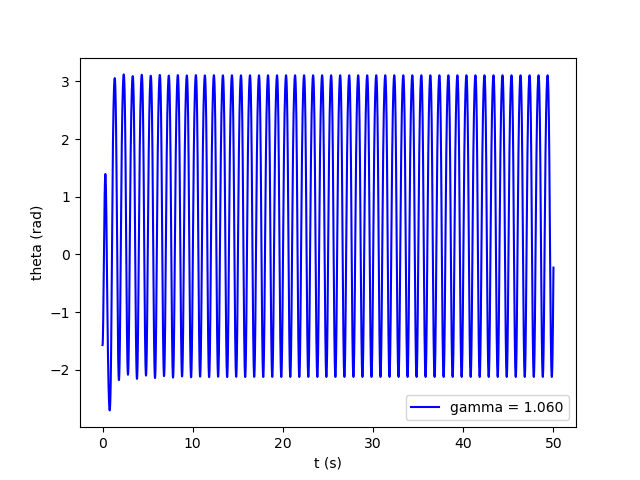

t (s) | theta (rad)
--- | ---
40 | -0.2466
41 | -0.2466
42 | -0.2466
43 | -0.2466
44 | -0.2466
45 | -0.2466
46 | -0.2466
47 | -0.2466
48 | -0.2466
49 | -0.2466

In [18]:
tdata, thetadata, omegadata, Fddata = run_pendulum(1.06, 3/4*np.pi, theta_i=-np.pi/2, omega_i=0, t_total = 50)

plot_theta(tdata, thetadata)

times = np.arange(40,50,1)
thetas = []

table="t (s) | theta (rad)\n--- | ---"

for t in times:
    index = np.abs(tdata-t).argmin()
    thetas.append(thetadata[index])
    table=table+"\n"+("%d | %.4f" % (t, thetadata[index]))

display(Markdown(table))

<IPython.core.display.Javascript object>


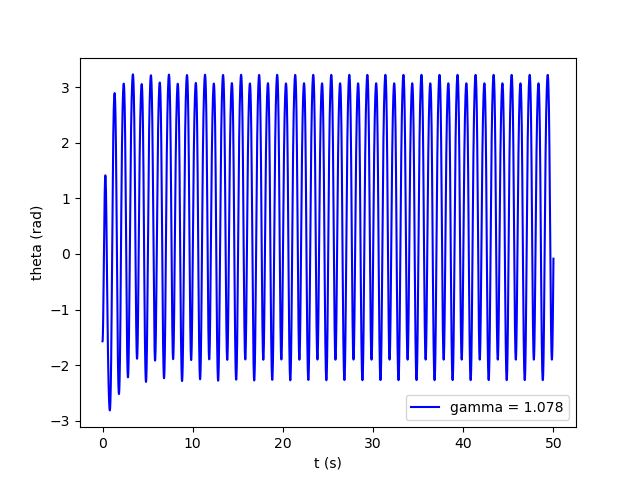

t (s) | theta (rad)
--- | ---
40 | -0.1033
41 | -0.4155
42 | -0.1034
43 | -0.4148
44 | -0.1033
45 | -0.4153
46 | -0.1034
47 | -0.4149
48 | -0.1033
49 | -0.4152

In [19]:
tdata, thetadata, omegadata, Fddata = run_pendulum(1.078, 3/4*np.pi, theta_i=-np.pi/2, omega_i=0, t_total = 50)

plot_theta(tdata, thetadata)

times = np.arange(40,50,1)
thetas = []

table="t (s) | theta (rad)\n--- | ---"

for t in times:
    index = np.abs(tdata-t).argmin()
    thetas.append(thetadata[index])
    table=table+"\n"+("%d | %.4f" % (t, thetadata[index]))

display(Markdown(table))

<IPython.core.display.Javascript object>


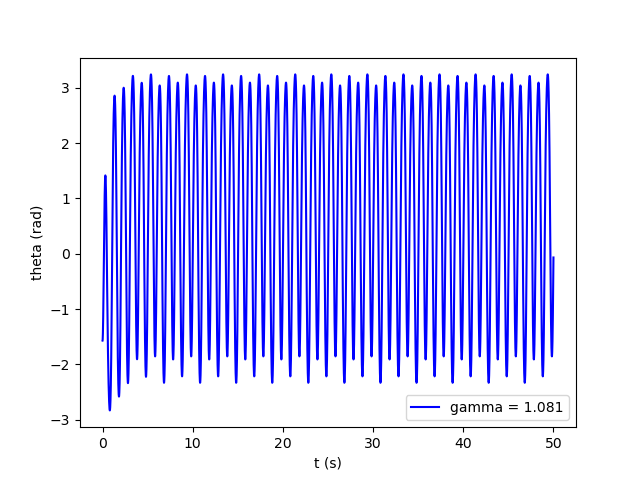

t (s) | theta (rad)
--- | ---
40 | -0.1091
41 | -0.3539
42 | -0.0856
43 | -0.5050
44 | -0.1091
45 | -0.3539
46 | -0.0856
47 | -0.5050
48 | -0.1091
49 | -0.3539

In [20]:
tdata, thetadata, omegadata, Fddata = run_pendulum(1.081, 3/4*np.pi, theta_i=-np.pi/2, omega_i=0, t_total = 50)

plot_theta(tdata, thetadata)

times = np.arange(40,50,1)
thetas = []

table="t (s) | theta (rad)\n--- | ---"

for t in times:
    index = np.abs(tdata-t).argmin()
    thetas.append(thetadata[index])
    table=table+"\n"+("%d | %.4f" % (t, thetadata[index]))

display(Markdown(table))

<IPython.core.display.Javascript object>


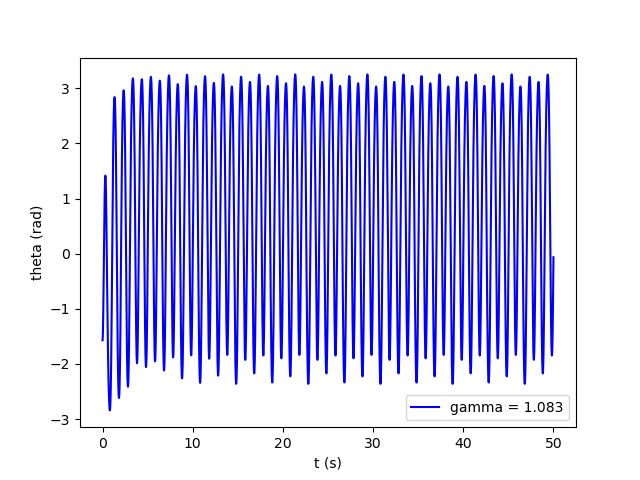

t (s) | theta (rad)
--- | ---
40 | -0.1167
41 | -0.3047
42 | -0.0829
43 | -0.5122
44 | -0.1034
45 | -0.3671
46 | -0.0787
47 | -0.5484
48 | -0.1166
49 | -0.3050

In [21]:
tdata, thetadata, omegadata, Fddata = run_pendulum(1.0826, 3/4*np.pi, theta_i=-np.pi/2, omega_i=0, t_total = 50)

plot_theta(tdata, thetadata)

times = np.arange(40,50,1)
thetas = []

table="t (s) | theta (rad)\n--- | ---"

for t in times:
    index = np.abs(tdata-t).argmin()
    thetas.append(thetadata[index])
    table=table+"\n"+("%d | %.4f" % (t, thetadata[index]))

display(Markdown(table))

## Feigenbaum Number

$\gamma_n$ is the value of $\gamma$ where the period doubles (called a **threshold** or **bifurcation point**). Here are the $\gamma_n$:

n | change in period | $\gamma_n$ 
--- | --- | ---
1 | transition: $1 \to 2$ | 1.0663
2 | transition: $2 \to 4$ | 1.0793
3 | transition: $4 \to 8$ | 1.0821
4 | transition: $8 \to 16$ | 1.0827

The Feigenbaum Delta Number is

$$\delta = \frac{\gamma_{n}-\gamma_{n-1}}{\gamma_{n+1}-\gamma_{n}}$$

## Exercises

### Exercise 1

Compute $\delta$ using the threshold data (or bifurcation points) above.

### Exercise 2

Review the calculation of the delta number for the logistic map. Compare to the delta number calculated for this system.

### Exercise 3

Period doubling continues, but with smaller and smaller intervals between threshold values. At some critical value $\gamma_c$, the system becomes chaotic. What is the critical value of $\gamma$ for this system?

### Exercise 4 - Qualities of Chaos

Here are two qualities of chaotic systems that are universal:

- Non-periodic long-term behavior (not predictable).
- Sensitivity to initial conditions.

To demonstrate the sensitivity to initial conditions, we start two oscillators with very slightly different initial angles. Define $\Delta \theta_{err}=|\theta_2-\theta_1|$.

1. By plotting $\Delta \theta_{err}$ for $\gamma=0.1$ and $\theta_{i2}-\theta_{i1}=0.1\ \mathrm{rad}$, show that the difference in $\theta$ for the two oscillators decreases exponentially and that they converge to the same oscillations. Do a linear fit and find the Lyapunov exponent.

2. Repeat for $\gamma=1.07$. Based on the graph, is this system chaotic?

3. Repeat for $\gamma=1.105$. Find the Lyapunov exponent.